<a href="https://colab.research.google.com/github/dosepix/DosepixCalibration/blob/main/DNN_calibration_large.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import dill
import tqdm

from keras import backend as K
from keras.layers import Input, Dense, Conv1D, Flatten, Reshape, AveragePooling1D, Lambda, Multiply, Add, Dropout, Concatenate, GaussianNoise
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.utils import plot_model
from keras.backend import mean
from keras.optimizers import Adam
from keras import losses, metrics, regularizers
import keras.callbacks
import tensorflow as tf

from IPython.display import Image
from IPython.core.display import HTML
import json

from google.colab import drive
drive.mount('/content/gdrive')

# p_norm = [2.5, 8.5, -55, -1.75]
p_norm = np.asarray( [1.85, 125.0, -275.0, 7.5] )
import os, sys
directory = '/content/gdrive/My Drive/Colab Notebooks/calib_data/'
sys.path.insert(0, directory)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from keras.models import load_model
from keras.layers import Layer
from keras.legacy import interfaces
SIMPLE = False

class GaussianConvolutionNoise(Layer):
    def __init__(self, stddev, **kwargs):
        super(GaussianConvolutionNoise, self).__init__(**kwargs)
        self.stddev = stddev

    def call(self, inputs, training=None):
        def noised():
            input_noise = inputs * (1 + K.random_normal(K.shape(inputs), stddev=np.random.uniform(0, self.stddev)))
            input_noise = K.switch(K.equal(inputs, 0.), K.zeros_like(inputs), input_noise)
            return K.clip(input_noise, 0, 1 + 3 * self.stddev)
        return K.in_train_phase(noised, inputs, training=training)

    def get_config(self):
        config = super().get_config()
        config['stddev'] = self.stddev
        return config

def ToTtoEnergySimple_keras(x, a, b, c, t):
    if SIMPLE:
        return b + 1./(4 * a) * (2*x + np.pi*c + K.sqrt(16 * a * c * t + (2 * x + np.pi * c)**2))
        # return 1./(4 * a) * (2*x + np.pi*c + 2*a*b + K.sqrt(16*a*c*t + (2*x + np.pi*c)**2 - 4*a*b*(np.pi*c - a*b + 2*x)))
    else:
        return 1./(2*a) * ( t*a + x - b + K.sqrt((b + t*a - x)**2 - 4*a*c) )

        res = np.where(x >= b, a*(x / h - b) - c * (np.pi / 2 + t / ((x - k) - b)), 0)

def peakPositionLoss(peakPositions):
    def loss(yTrue, yPred):
        mse_loss = K.mean(K.abs(yPred - yTrue), axis=-1)
        # peak_loss = ToTtoEnergySimple(peakPositions)

        a, b, c, t = [yPred[:, idx] for idx in range(4)]
        a *= p_norm[0]
        b *= p_norm[1]
        c *= p_norm[2]
        t *= p_norm[3]

        peak1, peak2 = peakPositions[:,0], peakPositions[:,1]
        energy1 = ToTtoEnergySimple_keras(peak1, a, b, c, t)
        energy2 = ToTtoEnergySimple_keras(peak2, a, b, c, t)

        peak_loss = K.mean(K.sqrt(K.square(energy1 - 17.04) + K.square(energy2 - 58.8)))
        return mse_loss + peak_loss
    return loss

input_peak = Input(shape=(2,))
loss = peakPositionLoss(input_peak)
adam = Adam(lr=0.0002)

# Large pixels
reg = load_model(directory + 'DNN_wPeakFit_newCalibFunc.h5', custom_objects={'GaussianConvolutionNoise': GaussianConvolutionNoise, 'loss': loss})
regressor = Model(input=[reg.input, input_peak], output=reg.output)
regressor.compile(optimizer=adam, loss=loss, metrics=['mae', 'acc'])

# Small pixels
reg_small = load_model(directory + 'DNN_wPeakFit_newCal_small_prag.h5', custom_objects={'GaussianConvolutionNoise': GaussianConvolutionNoise, 'loss': loss})
regressor_small = Model(input=[reg_small.input, input_peak], output=reg_small.output)
regressor_small.compile(optimizer=adam, loss=loss, metrics=['mae', 'acc'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [ ]:
# Is data already binned?
make_hist = False
# Ikrum = 20
# measurement = np.nan_to_num( json.load(open(directory + 'measurements/ToTMeasurement_22_None_None_Ikrum%d.json' % Ikrum, 'rb')) )
Ikrum = 30
# measurement = np.nan_to_num( json.load(open(directory + 'measurements/ToTMeasurement_Ikrum30_THL40_nacht/ToTMeasurement_24.json', 'rb')) )
# measurement = np.nan_to_num( json.load(open(directory + 'measurements/params_%s_Ikrum%d_hist.json' % ('prag', Ikrum), 'rb')) )
# measurement = np.nan_to_num( json.load(open(directory + 'measurements/ToTMeasurement_DPX35/Am_MoXRF.json', 'r')) )
measurement = np.nan_to_num( json.load(open(directory + 'measurements/params_%s_Ikrum%d_hist.json' % ('DPX35', Ikrum), 'r')))

histDict = {}
for slot in measurement.keys():
    if slot == 'bins':
        continue
    print(slot)
    hist = []
    for pixel in range(256):
        if make_hist:
            h, b = np.histogram(np.asarray(measurement[slot]).T[pixel], bins=np.arange(1, 402))
        else:
            h = np.asarray( measurement[slot][pixel] )
            b = np.arange(len(h))

        h = np.asarray(h, dtype=float)
        h /= float(np.max(h))
        hist.append( np.nan_to_num(h) )
    histDict[int(slot[-1])] = hist

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

3


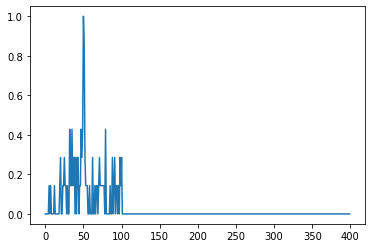

In [ ]:
t = np.asarray(histDict[3][0])
plt.plot(t)

In [ ]:
# titles = ['22', '6', '109']
titles = [None, None, 'prag']
largePixels = np.asarray( [pixel for pixel in np.arange(256) if pixel % 16 not in [0, 1, 14, 15]] )
smallPixels = np.asarray( [pixel for pixel in np.arange(256) if pixel % 16 in [0, 1, 14, 15]] )
pixels = [largePixels, smallPixels]

p_norm_large = [1.85, 125., -275., 7.5 ]
p_norm_small = [0.4, 100.0, -275.0, 7.5] 
p_norm = np.asarray([p_norm_large, p_norm_small])

regs = [regressor, regressor_small]
outDict = {}
for key in histDict.keys():
    if titles[int(key) - 1] is None:
        continue

    m = histDict[key]
    m = np.asarray(m).reshape((len(m), -1, 1))
    
    for idx in range(2):
        pred = regs[idx].predict([m[pixels[idx]], np.zeros((len(m[pixels[idx]]), 2))]) * p_norm[idx]
        a, b, c, t = pred.T
        for pixel_idx, pixel in enumerate(pixels[idx]):
            outDict[str(pixel)] = {'a': a[pixel_idx], 'b': b[pixel_idx], 'c': c[pixel_idx], 't': t[pixel_idx]}

    with open(directory + 'measurements/params_%s_Ikrum%d.json' % (titles[int(key) - 1], Ikrum), 'w') as f:
         json.dump(outDict, f, cls=NumpyEncoder)

In [ ]:
with open(directory + 'measurements/params_%s_Ikrum%d_hist.json' % ('DPX35', Ikrum), 'w') as f:
    json.dump(histDict, f, cls=NumpyEncoder)

In [ ]:
plt.hist([outDict[str(pixel)]['b'] for pixel in range(256)], bins=30)

NameError: ignored

In [ ]:
SIMPLE = False
def energyToToTSimple(x, a, b, c, t):
    if SIMPLE:
        thl = getTHL(a, b, c, t)
        res = np.where(x > thl, a*(x - b) - c * (np.pi / 2 + t / (x - b)), 0)
        # res = np.where(x > thl, a*x - c * (np.pi / 2 + t / (x - b)), 0)
        return res
    else:
	      return np.where(x >= getTHL(a, b, c, t), a*x + b + float(c)/(x - t), 0)

def ToTtoEnergySimple(x, a, b, c, t, h=1, k=0):
    if SIMPLE:
        return h * (b + 1./(4 * a) * (2*x + np.pi*c + np.sqrt(16 * a * c * t + (2 * x + np.pi * c)**2))) + k
    else:
      	return 1./(2*a) * ( t*a + x - b + np.sqrt((b + t*a - x)**2 - 4*a*c) )
       
def getTHL(a, b, c, t):
    if SIMPLE:
        return (4*a*b + np.sqrt(c * (16 * a * t + np.pi**2 * c)) + np.pi * c) / (4 * a)
    else:
        return 1./(2*a) * ( t*a - b + np.sqrt((b + t*a)**2 - 4*a*c) )

In [ ]:
for key in histDict.keys():
    for pixel in range(256):
        h = histDict[key][pixel]

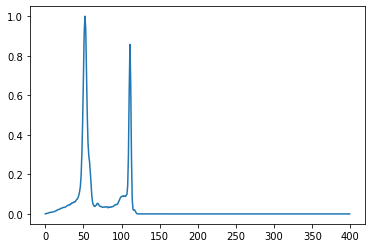

In [ ]:
plt.plot(histDict[3][2])

In [ ]:
measurement.keys()

dict_keys(['Slot3'])

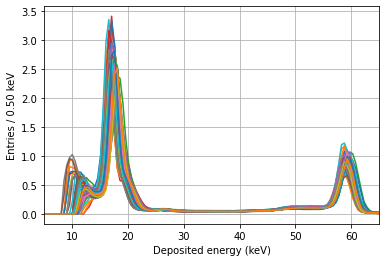

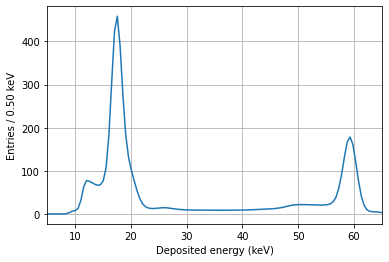

In [ ]:
import scipy.interpolate
bins_energy = np.linspace(0, 100, 200)

sum = np.zeros(len(bins_energy))
THL = []
for pixel in range(256):
    if pixel % 16 in [0, 1, 14, 15]: # or pixel == 41:
        THL.append(np.nan)
        continue
    bins = np.arange(400)
    p = outDict['%d' % pixel]
    a, b, c, t = p['a'], p['b'], p['c'], p['t']
    THL.append( getTHL(a, b, c, t) )
    bins_ = ToTtoEnergySimple(bins, a, b, c, t)
    f = scipy.interpolate.interp1d(bins_[:-1], 
          np.asarray(measurement['3'][pixel]).flatten()[:-1] / np.diff(bins_), bounds_error=False, fill_value=0)
    plt.plot(bins_energy, f(bins_energy))
    sum += f(bins_energy)
plt.xlim(5, 65)
# plt.ylim(0, 3.2)
plt.grid()
plt.xlabel('Deposited energy (keV)')
plt.ylabel('Entries / %.2f keV' % np.diff(bins_energy)[0])
plt.savefig('single_pixels_small.pdf', bbox_inches='tight')
plt.show()

plt.plot(bins_energy, sum)
plt.grid()
plt.xlabel('Deposited energy (keV)')
plt.ylabel('Entries / %.2f keV' % np.diff(bins_energy)[0])
plt.xlim(5, 65)
plt.savefig('sum_pixels_small.pdf', bbox_inches='tight')

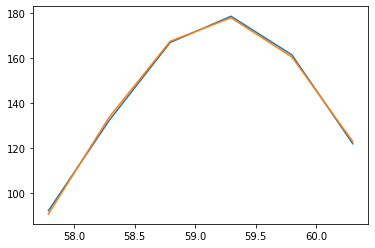

[178.02475166  59.23121332   1.24277342]


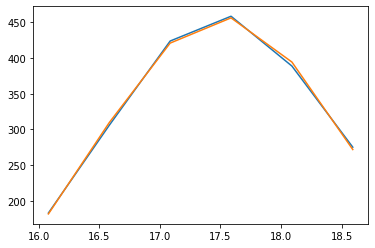

[457.36670734  17.51566612   1.05592252]


In [ ]:
def normal(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

for peak in [59, 17.5]:
    x, y = bins_energy, sum
    filt = np.abs(x - peak) < 1.5
    popt, pcov = scipy.optimize.curve_fit(normal, x[filt], y[filt], p0=(150, peak, 3))
    plt.plot(x[filt], y[filt])
    plt.plot(x[filt], normal(x[filt], *popt))
    plt.show()
    print(popt)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


10.854336372576157 0.58256477260982 10.983073313274705 12.15086876545283


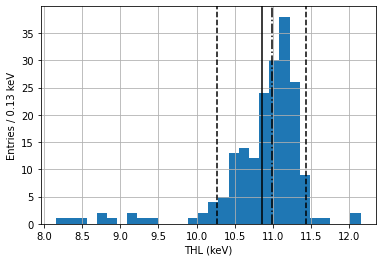

In [ ]:
h, b, c = plt.hist(THL, bins=30)
m, std, med = np.nanmean(THL), np.nanstd(THL), np.nanmedian(THL)
print(m, std, med, np.nanmax(THL))
plt.axvline(m, ls='-', color='k')
plt.axvline(med, ls='-.', color='k')
plt.axvline(x=m + std, ls='--', color='k')
plt.axvline(x=m - std, ls='--', color='k')

plt.grid()
plt.xlabel('THL (keV)')
plt.ylabel('Entries / %.2f keV' % np.diff(b)[-1])
plt.savefig('THL_large.pdf', bbox_inches='tight')

In [ ]:
bins = np.linspace(0, 70, 1000)
for pixel in range(2, 15):
    d = np.asarray(measurement['3']).T[pixel]
    d = d[d > 0]
    # plt.hist(d, bins=np.arange(400))
    # plt.show()

    p = outDict['%d' % pixel]
    a, b, c, t = p['a'], p['b'], p['c'], p['t']
    d = ToTtoEnergySimple(d, a, b, c, t)
    d, b = np.histogram(d, bins=bins)
    plt.step(bins[:-1], d)
    plt.show()

In [ ]:
lp = largePixels
# lp = np.delete(lp, 31)

In [ ]:
lp 

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  18,
        19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  34,  35,
        36,  37,  38,  39,  40,  42,  43,  44,  45,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  91,  92,  93,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
       173, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
       194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 210,
       211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 226, 227,
       228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 242, 24

0.6648133039474489 0.6652809098362923 0.033198257569056394
69.28141713142395 69.45397080853581 4.005243029885618
-283.7128162384033 -284.3060093931854 23.803014741620903
6.449839398264885 6.417498376686126 0.16960624947207947


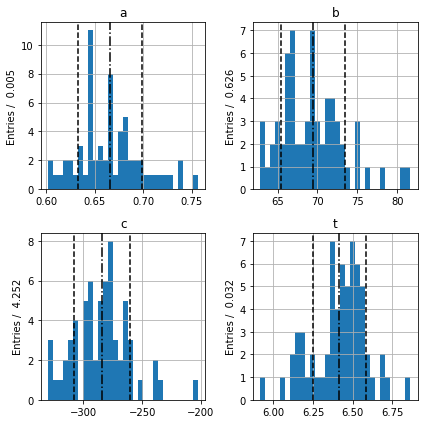

In [ ]:
def expFit(x, lam):
    return lam * np.exp(-lam * x)

fig, ax = plt.subplots(2, 2, figsize=(6, 6), sharex=False, sharey=False)
ax = ax.flatten()
titles=['a', 'b', 'c', 't']
bins = 30
bList = []
for idx in range(4):
    v = [outDict['%d' % pixel][titles[idx]] for pixel in smallPixels]
    h, b, s = ax[idx].hist(v, bins=bins, density=False)

    ax[idx].set_title(titles[idx])
    ax[idx].grid()
    print(np.median(v), np.mean(v), np.std(v))
    ax[idx].axvline(x=np.mean(v), color='k', ls='-.')
    ax[idx].axvline(x=np.mean(v) + np.std(v), color='k', ls='--')
    ax[idx].axvline(x=np.mean(v) - np.std(v), color='k', ls='--')

    ax[idx].set_ylabel('Entries /  %.3f' % np.diff(b)[0])

# axis labels
plt.tight_layout()
plt.savefig('dnn_calib_small.pdf')

In [ ]:
with open('DPX35_calib_params.csv', 'w') as f:
    json.dump(outDict, f, cls=NumpyEncoder)